# Import Pre-trained YOLOv8 model

In [2]:
# !pip install ultralytics


In [3]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kv32xaa4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kv32xaa4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-04-29 12:17:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.44, 18.165.83.35, 18.165.83.91, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   185MB/s    in 16s     

2024-04-29 12:17:49 (154 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [2]:
from ultralytics import YOLO

yolo_model = YOLO('/home/akash/S8/Fetal-VM-Reconstruction/YOLOv8/Saggittal_trained_YOLO_model/best.pt')

In [3]:
results = yolo_model.predict(source='/home/akash/S8/Fetal-VM-Reconstruction/YOLOv8/saggital_data/sagg_mri/2294008sag_1_1_1_10.jpg', conf=0.20)


image 1/1 /home/akash/S8/Fetal-VM-Reconstruction/YOLOv8/saggital_data/sagg_mri/2294008sag_1_1_1_10.jpg: 800x800 1 Ventricles, 10.1ms
Speed: 6.4ms preprocess, 10.1ms inference, 429.9ms postprocess per image at shape (1, 3, 800, 800)


In [4]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'Ventricles'}
 obb: None
 orig_img: array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
    

In [5]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[842.6314697265625, 950.6792602539062, 1184.823486328125, 1110.3626708984375]

# SAM Instance Segmentation
Feed the bounding boxes and the image to SAM and let it do the masking

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
sam_checkpoint = "/home/akash/S8/Fetal-VM-Reconstruction/YOLOv8/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam_model)

In [10]:
image = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/ColabNotebooks/YOLOv8/transverse/yolo_dataset/left_VM_test_transverse.jpg'), cv2.COLOR_BGR2RGB)
predictor.set_image(image)

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

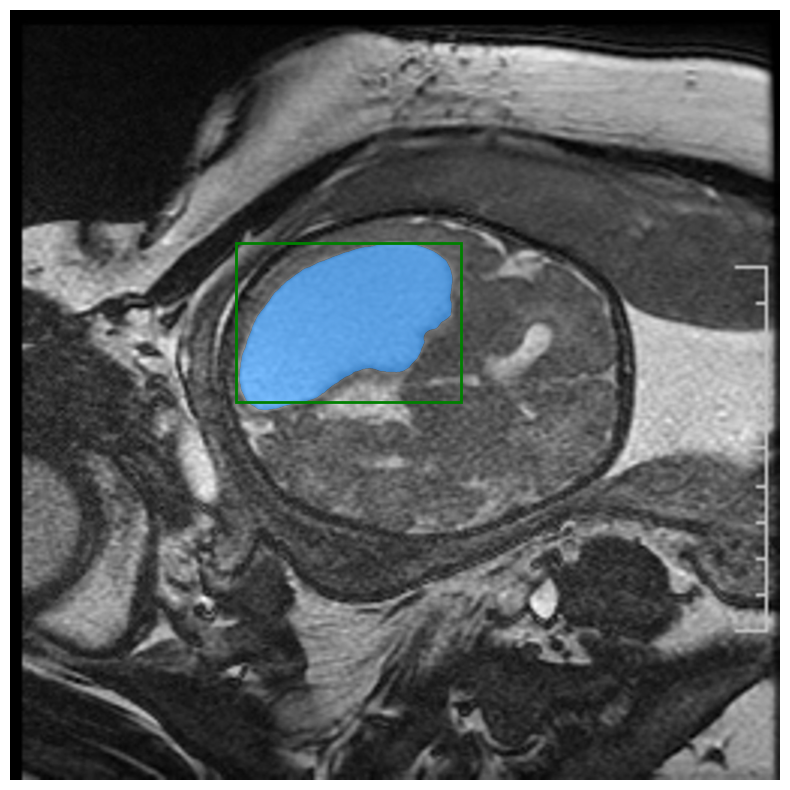

In [12]:
input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

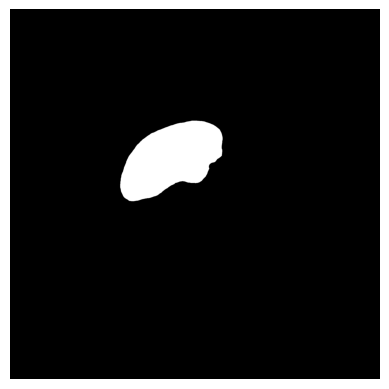

In [19]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

black_background = np.ones_like(image)*0

mask_color = np.array([255, 255, 255])  # White color

new_image = black_background * (1 - binary_mask[..., np.newaxis]) + mask_color * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()